In [3]:
import hashlib
import json
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [7]:
exp_dirs_code_hashes = [['../experiment_data/pilot_june9/', 'thowpbr_pilot0'],
                        ['../experiment_data/pilot_june12/', 'thowpbr_pilot0']]

csv_name = 'mturk.csv'
log_dir = 'www/log/'
feedback_dir = 'www/feedback'

MIN_GOLD_NAV = 4
MAX_GOLD_NAV = 35
MAX_NAV_LEN = 300
MAX_DIALOG_LEN = 60

tasks_fn = 'resources/house_target_tuple.json'
with open(tasks_fn, 'r') as f:
    house_target_tuple = json.load(f)

In [23]:
# Read in the CSV from Turk and connect each player to their respective logfile to rebuild games.
num_unpaired = 0
players = pd.DataFrame(columns=["wid", "uid", "pid", "role", "rating", "feedback"])
games = pd.DataFrame(columns=["navigator", "oracle", "navigator_quality", "oracle_quality",
                              "house", "target", "start_pano", "end_panos",
                              "success", "nav_trajectory", "dialog_history", "stop_history",
                              "num_nav_steps", "num_dialog_turns", "num_stop_attempts"])
for exp_dir, surveycode_hash in exp_dirs_code_hashes:
    print("Reading from '%s'" % exp_dir)
    mturk = pd.read_csv(os.path.join(exp_dir, csv_name))
    for idx in mturk.index:
        # Approve surveycode.
        surveycode = mturk['Answer.surveycode'][idx]
        wid = mturk['WorkerId'][idx]
        if '_' not in surveycode or surveycode.count('_') != 1:
            print('WARNING: worker %s has invalid surveycode "%s"' % (wid, surveycode))
            continue
        uid, hashcode = mturk['Answer.surveycode'][idx].split('_')
        hash_str = 'phm_salted_hash%s%s' % (uid, surveycode_hash)
        correcthash = hashlib.sha1(hash_str.encode('utf-8')).hexdigest()[:13]
        if correcthash != hashcode:
            print('WARNING: worker %s has wrong hash %s does not match target %s' % (wid, hashcode, correcthash))
            continue

        # Find the feedback file for this user.
        uid_feedback_fn = None
        for _, _, fns in os.walk(os.path.join(exp_dir, feedback_dir)):
            for fn in fns:
                if fn.split('.')[-1] == 'json' and fn.split('_')[0] == uid:
                    uid_feedback_fn = os.path.join(exp_dir, feedback_dir, fn)
        if uid_feedback_fn is None:
            print('WARNING: worker %s with uid %s has no feedback file' % (wid, uid))
            continue
        with open(uid_feedback_fn) as f:
            feedback = json.load(f)
        if len(feedback['navigator']) == 0 or len(feedback['oracle']) == 0:
            num_unpaired += 1
            continue
        role = 'navigator' if feedback['navigator'] == uid else 'oracle'
        pid_role = 'navigator' if role == 'oracle' else 'oracle'
        pid = feedback['navigator'] if role == 'oracle' else feedback['oracle']
        pid_rating = int(feedback['rating']) if feedback['rating'] is not None else None
        str_feedback = feedback['free_form_feedback']

        # Add self and partner to players dataframe.
        if pid_rating is None:
            continue
        for add_uid in [uid, pid]:
            if add_uid not in players['uid'].tolist():
                players = players.append({
                            "wid": None,
                            "uid": add_uid,
                            "pid": None,
                            "role": None,
                            "rating": None,
                            "feedback": None,
                        }, ignore_index=True)
        uid_idx = players.index[players['uid'] == uid].tolist()[0]
        players['wid'][uid_idx] = wid
        players['pid'][uid_idx] = pid
        players['role'][uid_idx] = role
        players['feedback'][uid_idx] = str_feedback
        pid_idx = players.index[players['uid'] == pid].tolist()[0]
        players['rating'][pid_idx] = pid_rating

        # Already have game information for this user.
        if pid in games['navigator'].tolist():
            gidx = games.index[games['navigator'] == pid].tolist()[0]
            games['oracle'][gidx] = uid
            games['navigator_quality'][gidx] = pid_rating
            continue
        elif pid in games['oracle'].tolist():
            gidx = games.index[games['oracle'] == pid].tolist()[0]
            games['navigator'][gidx] = uid
            games['oracle_quality'][gidx] = pid_rating
            continue

        # Find the logfile and partner id for this user.
        for _, _, fns in os.walk(os.path.join(exp_dir, log_dir)):
            for fn in fns:
                if ('.' in fn and fn.split('.')[-1] == 'log' and
                    '_' in fn and uid in fn.split('.')[0].split('_') and pid in fn.split('.')[0].split('_')):

                    # Need to create game information for this unseen pair.
                    navigator = oracle = navigator_quality = oracle_quality = None
                    house = target = start_pano = end_panos = None
                    success = False
                    nav_trajectory = [None] * MAX_NAV_LEN
                    dialog_history = [None] * MAX_DIALOG_LEN
                    stop_history = [None] * MAX_DIALOG_LEN
                    num_nav_steps = num_dialog_turns = num_stop_attempts = 0
                    curr_pano = None
                    curr_turn = "navigator"
                    with open(os.path.join(exp_dir, log_dir, fn)) as f:
                        logfile_lines = f.readlines()
                        for line in logfile_lines:
                            time, sender, data_str = line.strip().split('\t')
                            data_str = re.sub(r'(?!(([^"]*"){2})*[^"]*$)\'', "\\'", data_str)
                            data_str = data_str.replace("'", '"')
                            line_data = json.loads(data_str)

                            if line_data['action'] == 'set_house':
                                house = line_data['value']
                            elif line_data['action'] == 'set_target_obj':
                                target = line_data['value']
                            elif line_data['action'] == 'set_start_pano':
                                start_pano = line_data['value']
                                curr_pano = start_pano
                                nav_trajectory[num_nav_steps] = curr_pano
                                num_nav_steps += 1
                            elif line_data['action'] == 'set_end_panos':
                                end_panos = line_data['value'].split(',')
                            elif line_data['action'] == 'enable_nav':
                                navigator = uid
                                oracle = pid
                                oracle_quality = pid_rating
                            elif line_data['action'] == 'show_gold_view':
                                oracle = uid
                                navigator = pid
                                navigator_quality = pid_rating
                            elif line_data['action'] == 'nav' and line_data['message']['img_id'] != curr_pano:
                                curr_pano = line_data['message']['img_id']
                                nav_trajectory[num_nav_steps] = curr_pano
                                num_nav_steps += 1
                            elif line_data['action'] == 'chat':
                                if curr_turn == role:
                                    dialog_history[num_dialog_turns] = {"uid": uid,
                                                                        "role": role,
                                                                        "nav_idx": num_nav_steps - 1,
                                                                        "message": line_data['message']}
                                else:
                                    dialog_history[num_dialog_turns] = {"uid": pid,
                                                                        "role": pid_role,
                                                                        "nav_idx": num_nav_steps - 1,
                                                                        "message": line_data['message']}
                                num_dialog_turns += 1
                                curr_turn = "navigator" if curr_turn == "oracle" else "oracle"
                            elif line_data['action'] == 'guess_stop':
                                stop_history[num_stop_attempts] = num_nav_steps
                                num_stop_attempts += 1
                            elif line_data['action'] == 'set_aux' and 'Congrats, ' in line_data['message']:
                                success = True

                        games = games.append({
                            "navigator": navigator,
                            "oracle": oracle,
                            "navigator_quality": navigator_quality,
                            "oracle_quality": oracle_quality,
                            "house": house,
                            "target": target,
                            "start_pano": start_pano,
                            "end_panos": end_panos,
                            "success": success,
                            "nav_trajectory": nav_trajectory,
                            "dialog_history": dialog_history,
                            "stop_history": stop_history,
                            "num_nav_steps": num_nav_steps,
                            "num_dialog_turns": num_dialog_turns,
                            "num_stop_attempts": num_stop_attempts,
                        }, ignore_index=True)
print("Got %d players over %d games; %d players were left unpaired" % (len(players), len(games), num_unpaired))

Reading from '../experiment_data/pilot_june9/'
Reading from '../experiment_data/pilot_june12/'
Got 24 players over 12 games; 16 players were left unpaired


In [24]:
# See players' success rates and ratings.
player_ratings = {}
player_success = {}
for idx in players.index:
    wid = players['wid'][idx]
    if wid not in player_ratings:
        player_ratings[wid] = []
        player_success[wid] = []
    player_ratings[wid].extend(games[games['navigator'] == players['uid'][idx]]['navigator_quality'])
    player_ratings[wid].extend(games[games['oracle'] == players['uid'][idx]]['oracle_quality'])
    player_success[wid].extend(games[games['navigator'] == players['uid'][idx]]['success'])
for wid in player_ratings:
    print(wid, player_ratings[wid], player_success[wid])

A272X64FOZFYLB [5] []
A2UTDZAZV1DF0N [5] []
A3APKUC67F9IMW [4] [True]
A248LF7KKHXZ14 [5] [True]
A2HC9549CZAKNN [3] [True]
A1IZ4NX41GKU4X [2] []
A14Z1JSAR9JEON [4] []
AUFUUD4WG9CVO [5] []
A2TUUIV61CR0C7 [5] []
AAIQLE701DI9U [1] [True]
A17TKHT8FEVH0R [3] []
A10JXOU89D5RXR [5] []
A3W6T1WDYXMR3 [5] [True]
AZOK0NYBJ9ZCS [3] [True]
A2EKR2ZFO10VMV [2] [True]
A27OFCQG73Z4UF [5] [True]
ALF9AAZGQP4K5 [2] []
A3CH1Z6J9R38G9 [4] []
AOIK8K4X34LGR [5] [True]
A13CXQGLSH6QY8 [5] []
A3CWEIEY3TGJFX [5] [True]
A3QEVFM3UD67BA [4] [True]
A1WR3WTEHJEY2D [4] [True]
AOS2PVHT2HYTL [3] []


10	6	(0.60)
20	16	(0.80)
31	13	(0.42)
38	13	(0.34)
27	19	(0.70)
36	25	(0.69)
50	35	(0.70)
48	9	(0.19)
26	19	(0.73)
19	15	(0.79)


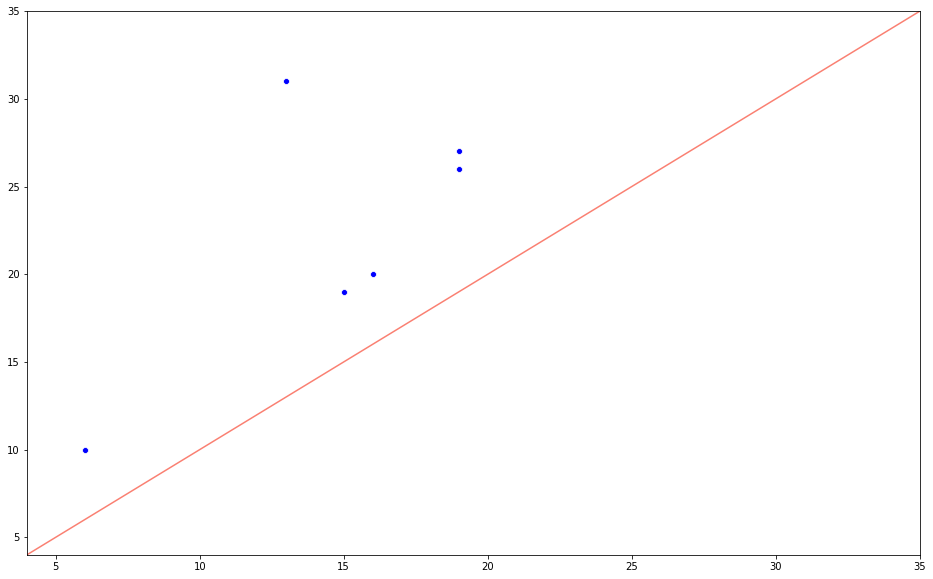

In [25]:
# Nav lengths against shortest path for completed games.
player_lens = []
shortest_lens = []
for idx in games.index:
    if not games['success'][idx]:
        continue
    player_traj_len = games['num_nav_steps'][idx]
    shortest_traj_len = None
    for obj, start_pano, _, end_panos, end_pano_ds in house_target_tuple[games['house'][idx]]:
        if (start_pano == games['start_pano'][idx] and
                obj == games['target'][idx] and
                set(end_panos) == set(games['end_panos'][idx])):
            shortest_traj_len = min(end_pano_ds)
    if shortest_traj_len is not None:
        print("%d\t%d\t(%.2f)" % (player_traj_len, shortest_traj_len, float(shortest_traj_len / player_traj_len)))
        player_lens.append(player_traj_len)
        shortest_lens.append(shortest_traj_len)
    else:
        print("WARNING: task for house %s, target '%s' missing" % (games['house'][idx], games['target'][idx]))
        
# Scatterplot showing how well players did against gold shortest.
fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.scatterplot(ax=ax, x=shortest_lens, y=player_lens, color='blue')
g2 = sns.lineplot(ax=ax, x=[MIN_GOLD_NAV, MAX_GOLD_NAV], y=[MIN_GOLD_NAV, MAX_GOLD_NAV], color='salmon')  # Perfect
ax.set(xlim=(MIN_GOLD_NAV, MAX_GOLD_NAV), ylim=(MIN_GOLD_NAV, MAX_GOLD_NAV))
plt.show()

37	11	(3.36)
10	1	(10.00)
20	11	(1.82)
131	19	(6.89)
31	5	(6.20)
38	13	(2.92)
27	9	(3.00)
36	11	(3.27)
50	21	(2.38)
48	17	(2.82)
26	7	(3.71)
19	5	(3.80)


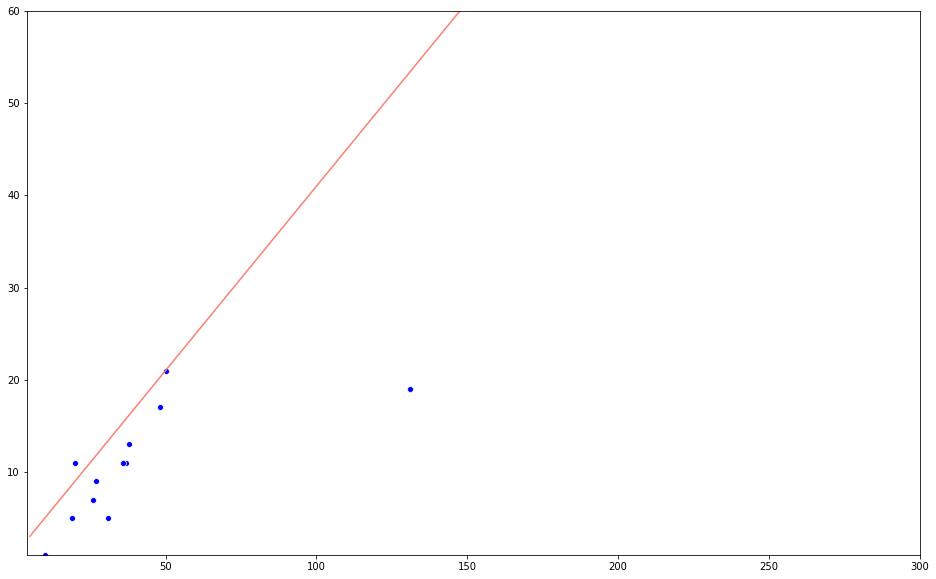

In [26]:
# Nav lengths against dialog lengths for completed games
nav_lens = []
dialog_lens = []
for idx in games.index:
    if not games['success'][idx]:
        continue
    nav_len = games['num_nav_steps'][idx]
    dialog_len = games['num_dialog_turns'][idx] + 1  # Counts the initial "hint" as a turn to avoid div by zero
    print("%d\t%d\t(%.2f)" % (nav_len, dialog_len, float(nav_len / dialog_len)))
    nav_lens.append(nav_len)
    dialog_lens.append(dialog_len)
        
# Scatterplot showing how well players did against gold shortest.
fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.scatterplot(ax=ax, x=nav_lens, y=dialog_lens, color='blue')
# "Conservative", asking 1 question every 5 nav turns, gives 2 dialog turns per 5 nav, with an offset of +1 for hint.
g2 = sns.lineplot(ax=ax, x=[5, 5*MAX_DIALOG_LEN], y=[2+1, (2*MAX_DIALOG_LEN)+1], color='salmon')
ax.set(xlim=(MIN_GOLD_NAV, MAX_NAV_LEN), ylim=(1, MAX_DIALOG_LEN))
plt.show()

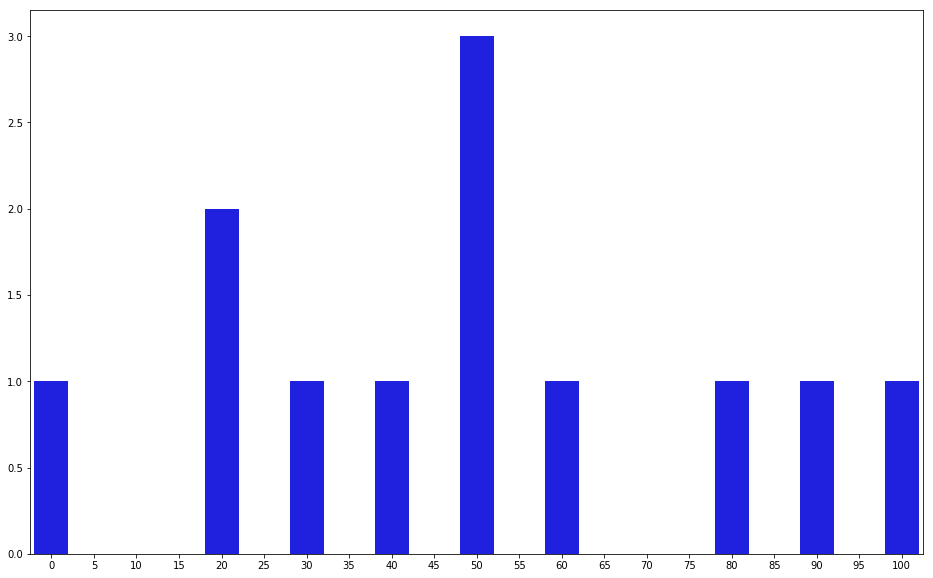

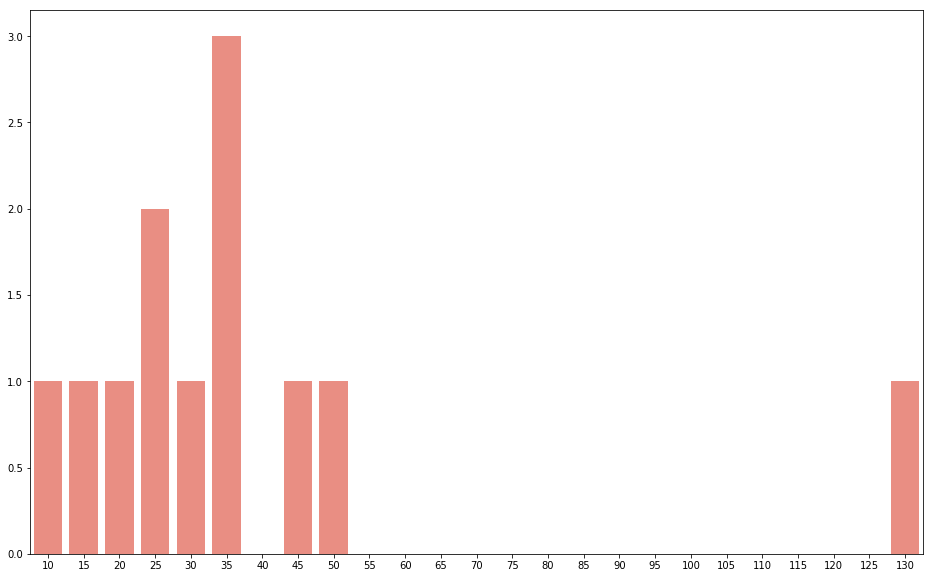

In [27]:
# Distribution of trajectory and dialog lengths.

# Dialog lens.
bin_size = 1
freq_of_dialog_count_bins = {}
for idx in games.index:
    if not games['success'][idx]:
        continue
    c = games['num_dialog_turns'][idx]
    cbin = c // bin_size
    if cbin not in freq_of_dialog_count_bins:
        freq_of_dialog_count_bins[cbin] = 0
    freq_of_dialog_count_bins[cbin] += 1
for cbin in range(min(freq_of_dialog_count_bins), max(freq_of_dialog_count_bins)):
    if cbin not in freq_of_dialog_count_bins:
        freq_of_dialog_count_bins[cbin] = 0
        
# Nav lens.
bin_size = 5
freq_of_nav_count_bins = {}
for idx in games.index:
    if not games['success'][idx]:
        continue
    c = games['num_nav_steps'][idx]
    cbin = c // bin_size
    if cbin not in freq_of_nav_count_bins:
        freq_of_nav_count_bins[cbin] = 0
    freq_of_nav_count_bins[cbin] += 1
for cbin in range(min(freq_of_nav_count_bins), max(freq_of_nav_count_bins)):
    if cbin not in freq_of_nav_count_bins:
        freq_of_nav_count_bins[cbin] = 0

fig1, ax1 = plt.subplots(figsize=(16, 10))
g1 = sns.barplot(ax=ax1,
                 x=[k * bin_size for k in freq_of_dialog_count_bins],
                 y=[freq_of_dialog_count_bins[k] for k in freq_of_dialog_count_bins],
                 color="blue")
fig2, ax2 = plt.subplots(figsize=(16, 10))
g2 = sns.barplot(ax=ax2,
                 x=[k * bin_size for k in freq_of_nav_count_bins],
                 y=[freq_of_nav_count_bins[k] for k in freq_of_nav_count_bins],
                 color="salmon")
plt.show()

In [ ]:
# TODO - distribution of dialog lengths
# TODO - language fertility analyses
    # TODO - 1-grams
    # TODO - differences between questioner and answerer
    # TODO - question/answer length as dialog grows longer

In [28]:
# Inspect open feedback.
for idx in players.index:
    if players['feedback'][idx] is not None and len(players['feedback'][idx]) > 0:
        print("%s: %s" % (players['uid'][idx], players['feedback'][idx].strip()))

5cfd5e36be024: They wandered around for a bit before asking, but otherwise asked pretty well.
5cfd5da427022: They never said anything, so I couldn't do anything.
5cfd5daab01cc: I had a strong idea of where the room was based on their comment.
5cfd6b84b33ac: It was easy but my partner and I understood eachother so maybe that's not always the case
5cfd6bd174a0b: this was fun
5cfd729b21a0e: He took up almost all of my time! Yeesh, not a good partner.
5cfd72052692c: This was ridiculous.  That wasn't a bathtub it was a shower.  And this hit was grossly underpaid.  Thanks for wasting my time.
5d016fe0ad042: It was hard to type into the interface. It drops character unless you type slow and hard.
5d0167607eb0b: they were a bit blunt which didnt help much
5d01675c7b713: I don't think the hint was very good.
5d01694daf191: We worked well together but I would think of a bookcase as a "bookcase" with books in it.
5d01690491008: Very fun and interesting task!
5d016cd6c8ba1: Once my partner underst

In [29]:
# Inspect dialogs.
for idx in games.index:
    print("house %s, target %s, dialog len %d, nav len %d, success: " %
          (games['house'][idx], games['target'][idx], games['num_dialog_turns'][idx], games['num_nav_steps'][idx]) +
          str(games['success'][idx]))
    print("navigator quality: %d, oracle quality: %d" % (games['navigator_quality'][idx], games['oracle_quality'][idx]))
    for tidx in range(games['num_dialog_turns'][idx]):
        turn = games['dialog_history'][idx][tidx]
        print("\t[%d] %s(%s):\t%s" % (turn['nav_idx'], turn['role'], turn['uid'], turn['message']))
    print()

house wc2JMjhGNzB, target bathtub, dialog len 10, nav len 37, success: True
navigator quality: 2, oracle quality: 5
	[7] navigator(5cfd5de1c26d1):	Should I go to the right or to the left through the door ahead?
	[7] oracle(5cfd5e36be024):	The right
	[9] navigator(5cfd5de1c26d1):	Should I go to the left or to the right?
	[9] oracle(5cfd5e36be024):	I think you can only go left
	[22] navigator(5cfd5de1c26d1):	Which direction should I turn next?
	[22] oracle(5cfd5e36be024):	Right
	[25] navigator(5cfd5de1c26d1):	Now where should I go?
	[25] oracle(5cfd5e36be024):	Go straight until you run into the paintings at the end of the hall.
	[30] navigator(5cfd5de1c26d1):	Okay, should I turn left or right this time?
	[30] oracle(5cfd5e36be024):	Go left and keep going that way until you get to the bedroom. It"s in the adjoined room to the bedroom.

house 17DRP5sb8fy, target toiletpaper, dialog len 0, nav len 10, success: True
navigator quality: 1, oracle quality: 4

house 17DRP5sb8fy, target sink, dia